### IMPORT LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [5]:
#train_dataset = tf.keras.preprocessing.image_dataset_from_directory('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
#                                                                        validation_split=0.2,
#                                                                        subset="training",
#                                                                        shuffle=False,
#                                                                        image_size=(224,224),
#                                                                        batch_size=32,
#                                                                        )

train_dataset  = train_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [6]:
#valid_dataset = tf.keras.preprocessing.image_dataset_from_directory('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
#                                                                        validation_split=0.2,
#                                                                        subset="validation",
#                                                                        shuffle=False,
#                                                                        image_size=(224,224),
#                                                                        batch_size=32,
#                                                                        )
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [7]:
#test_dataset = tf.keras.preprocessing.image_dataset_from_directory("../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test",
##                                                            shuffle=False,
#                                                            image_size=(224,224),
#                                                            batch_size=32,
#)

test_dataset = test_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1279 images belonging to 4 classes.


## feature preprocessing and label encoding.

### MODEL BUILDING

In [8]:
base_model = ResNet50(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

94773248/94765736 [==============================] - 1s 0us/step


In [9]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [10]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [11]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)                0

In [12]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [13]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [14]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [16]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        verbose = 1,
                         callbacks=lr_scheduler)

Epoch 1/20
129/129 [==============================] - 66s 511ms/step - loss: 1.0890 - accuracy: 0.7485 - precision: 0.4946 - recall: 0.2692 - auc: 0.7690 - f1_score: 0.3470 - val_loss: 1.0437 - val_accuracy: 0.7603 - val_precision: 0.5981 - val_recall: 0.1251 - val_auc: 0.7943 - val_f1_score: 0.2021
Epoch 2/20
129/129 [==============================] - 51s 397ms/step - loss: 1.0398 - accuracy: 0.7621 - precision: 0.5466 - recall: 0.2833 - auc: 0.7869 - f1_score: 0.3681 - val_loss: 1.0436 - val_accuracy: 0.7764 - val_precision: 0.6262 - val_recall: 0.2620 - val_auc: 0.7969 - val_f1_score: 0.3644
Epoch 3/20
129/129 [==============================] - 51s 397ms/step - loss: 1.0324 - accuracy: 0.7646 - precision: 0.5524 - recall: 0.3075 - auc: 0.7893 - f1_score: 0.3949 - val_loss: 1.0228 - val_accuracy: 0.7808 - val_precision: 0.6090 - val_recall: 0.3441 - val_auc: 0.8040 - val_f1_score: 0.4373
Epoch 4/20
129/129 [==============================] - 52s 400ms/step - loss: 1.0289 - accuracy: 0

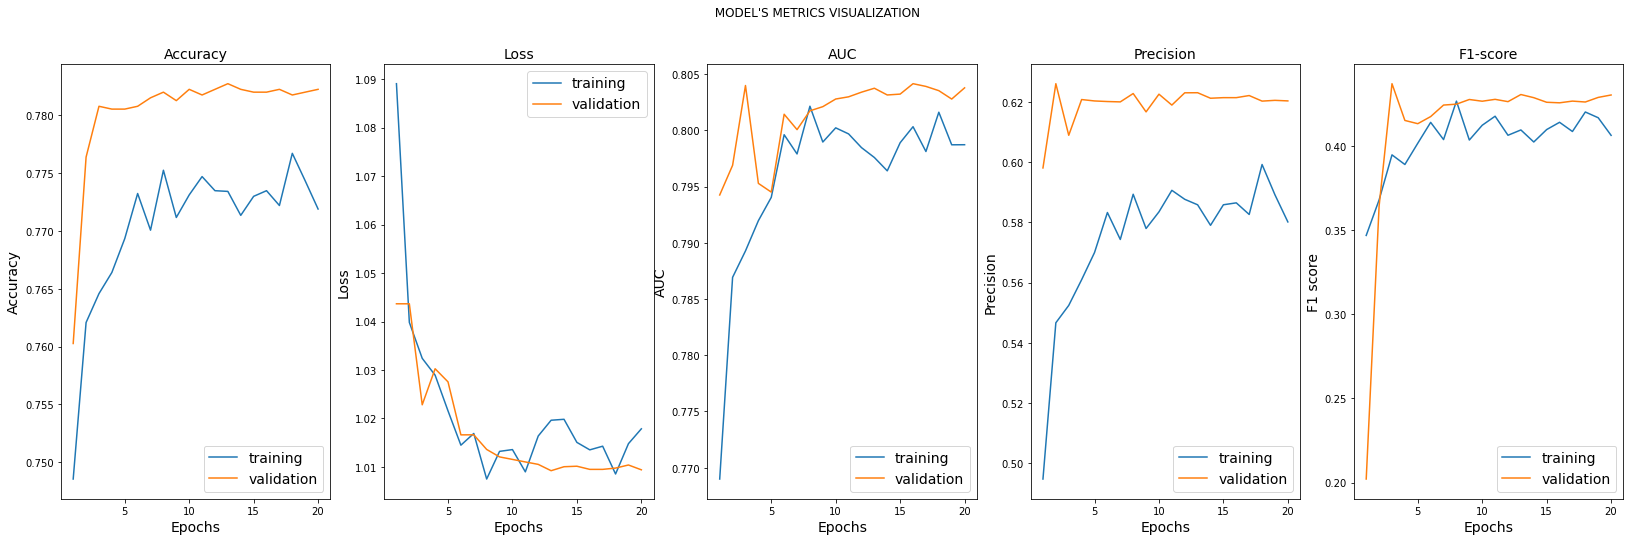

In [35]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (28,8))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Accuracy',fontsize=14)
    ax1.set_xlabel('Epochs',fontsize=14)
    ax1.set_ylabel('Accuracy',fontsize=14)
    ax1.legend(['training', 'validation'],fontsize=14)


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss',fontsize=14)
    ax2.set_xlabel('Epochs',fontsize=14)
    ax2.set_ylabel('Loss',fontsize=14)
    ax2.legend(['training', 'validation'],fontsize=14)
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('AUC',fontsize=14)
    ax3.set_xlabel('Epochs',fontsize=14)
    ax3.set_ylabel('AUC',fontsize=14)
    ax3.legend(['training', 'validation'],fontsize=14)
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('Precision',fontsize=14)
    ax4.set_xlabel('Epochs',fontsize=14)
    ax4.set_ylabel('Precision',fontsize=14)
    ax4.legend(['training', 'validation'],fontsize=14)
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('F1-score',fontsize=14)
    ax5.set_xlabel('Epochs',fontsize=14)
    ax5.set_ylabel('F1 score',fontsize=14)
    ax5.legend(['training', 'validation'],fontsize=14)


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [36]:
scores = model.evaluate_generator(test_dataset)

In [37]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.7695465087890625
Precision =  0.6041666865348816
Recall =  0.22673964500427246
AUC =  0.7976563572883606
F1_score =  0.32626599073410034


NameError: name 'pred_labels' is not defined